In [132]:
#from the py_geospatial environment
import glob
import os
import baseflow #this is the baseflow package
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pickle
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature  
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

#use segoe font
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Segoe UI'

#### Read observed discharge data

Observed discharge data from all station was pickled from the flow_evaluation notebook

In [117]:
#flow data
src = "W:/VUB/_main_research/mHM/model_validation_data/waterinfo_csv/waterinfo_timeseries"

#pickled Q data for all stations (from the flow_evaluation.ipynb script)
with open('eval_stations_Q.pickle', 'rb') as f:
    eval_stations_Q = pickle.load(f)

#station coordinates
station_locations = pd.read_csv("mHM_Q_eval_stations.csv", index_col=0)

#Boundaries data
be_shp = gpd.read_file(r"W:/VUB/_main_research/mHM/mhm_belgium/be_shp/be.shp")

#rivers
rivers_shp = gpd.read_file(r"W:/VUB/_main_research/data/shapefiles/HydroRIVERS_v10_eu_shp/HydroRIVERS_v10_eu_shp/hydroRivers_BE.shp")

#### Baseflow filter with different methods

In [ ]:
#dictionary to store the results
baseflow_dict= {}
bfi_dict = {}
kge_dict = {}


for key, data in eval_stations_Q.items():
    #read the data
    nameStation = key

    df = eval_stations_Q[nameStation]

    print(f'Processing {nameStation}', end='\r')
    df_baseflow, bfi, df_kge = baseflow.separation(df, return_bfi=True, return_kge=True) # to select a method, use the `method` parameter

    #choose best method based on KGE
    best_method = df_kge.idxmax(axis=1).iloc[0]  #iloc[0] grabs the station name from the index

    #extract the KGE for the best method
    kge_dict[nameStation] = np.round(df_kge[best_method].iloc[0], 3)

    #extract the baseflow timeseries for the best method
    df_q = df_baseflow[best_method]

    #get the bfi based on the best method
    bfi_dict[nameStation] = np.round(bfi[best_method].iloc[0],3)

    #Get the Qtotal and Qbaseflow for the station
    df_stat = pd.concat([df, df_q], axis=1)
    df_stat.columns = ['Q', 'Q_bf']

    baseflow_dict[nameStation] = df_stat

#### Convert to geodataframe

In [100]:
#combine the bfi, kge and station locations into a dataframe
df_bfi = pd.DataFrame.from_dict(bfi_dict, orient='index', columns=['BFI'])
df_kge = pd.DataFrame.from_dict(kge_dict, orient='index', columns=['KGE'])

#combine the bfi, kge and station locatiobs dataframes on index
df_bfi_kge = pd.concat([df_bfi, df_kge, station_locations], axis=1).dropna()

#convert to geodataframe
gdf_bfi_kge = gpd.GeoDataFrame(df_bfi_kge, geometry=gpd.points_from_xy(df_bfi_kge['lon'], df_bfi_kge['lat']))

#### Map BFI 

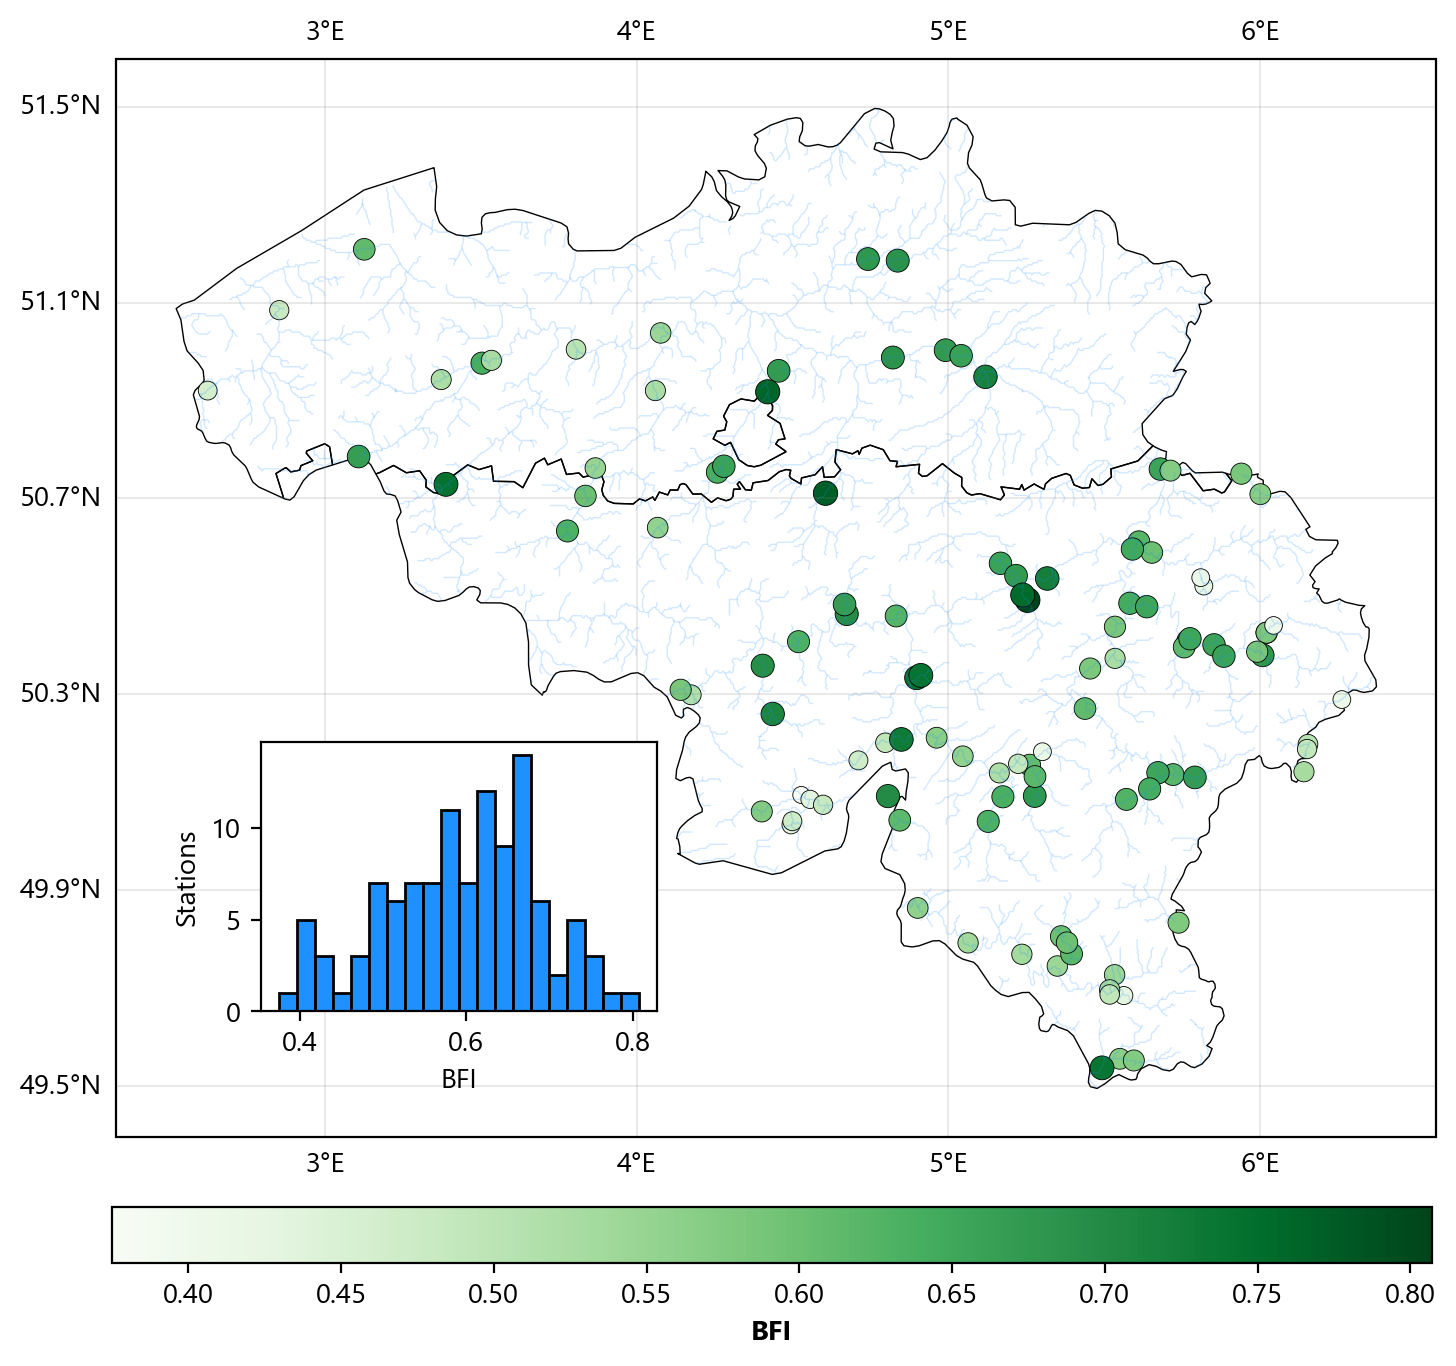

In [154]:
#### Map the BFI and KGE values
fig, ax = plt.subplots(figsize=(15, 7), subplot_kw={'projection': ccrs.PlateCarree()}, dpi=200)

be_shp.plot(ax=ax, linewidth=0.5,
              edgecolor='black', facecolor='none', zorder=1, transform=ccrs.PlateCarree())

rivers_shp.plot(ax=ax, linewidth=0.5, alpha=0.2,
                edgecolor='dodgerblue', facecolor='none', zorder=2, transform=ccrs.PlateCarree())


sc = ax.scatter(
    gdf_bfi_kge.geometry.x, gdf_bfi_kge.geometry.y,
    c=gdf_bfi_kge['BFI'],
    s=gdf_bfi_kge['BFI']*100,
    cmap='Greens',
    #norm=norm,
    edgecolor='black',
    linewidth=0.3,
    transform=ccrs.PlateCarree()
)

gl = ax.gridlines(draw_labels=True, color='gray', lw=0.6, alpha=0.2)
gl.xlocator = plt.FixedLocator(np.arange(0, 10, 1))
gl.ylocator = plt.FixedLocator(np.arange(49.5, 51.9, 0.4))
gl.top_labels = True
gl.right_labels = False

#Insert inset histogram of BFI values
ax_inset = inset_axes(ax, width="30%", height="25%", bbox_to_anchor=(-.58, -.62, 1.0, 1.0), bbox_transform=ax.transAxes)
gdf_bfi_kge['BFI'].plot(kind='hist', ax=ax_inset, bins=20, color='dodgerblue', edgecolor='black')
ax_inset.set_ylabel('Stations')
ax_inset.set_xlabel('BFI')
#ax_inset.set_title('BFI Histogram')

# Shared colorbar
#Add colorbar
cax = fig.add_axes([0.291, 0.02, 0.44, 0.04]) #left, bottom, width, height
# Shared normalization
stat_min = gdf_bfi_kge['BFI'].min()
stat_max = gdf_bfi_kge['BFI'].max()
cmap = 'Greens'  # You can change this to any colormap you prefer
norm = Normalize(vmin=stat_min, vmax=stat_max)
cmap = plt.get_cmap(cmap)

cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='horizontal')
cbar.ax.tick_params(labelsize=10)
cbar.set_label('BFI', fontsize=10, weight='bold')

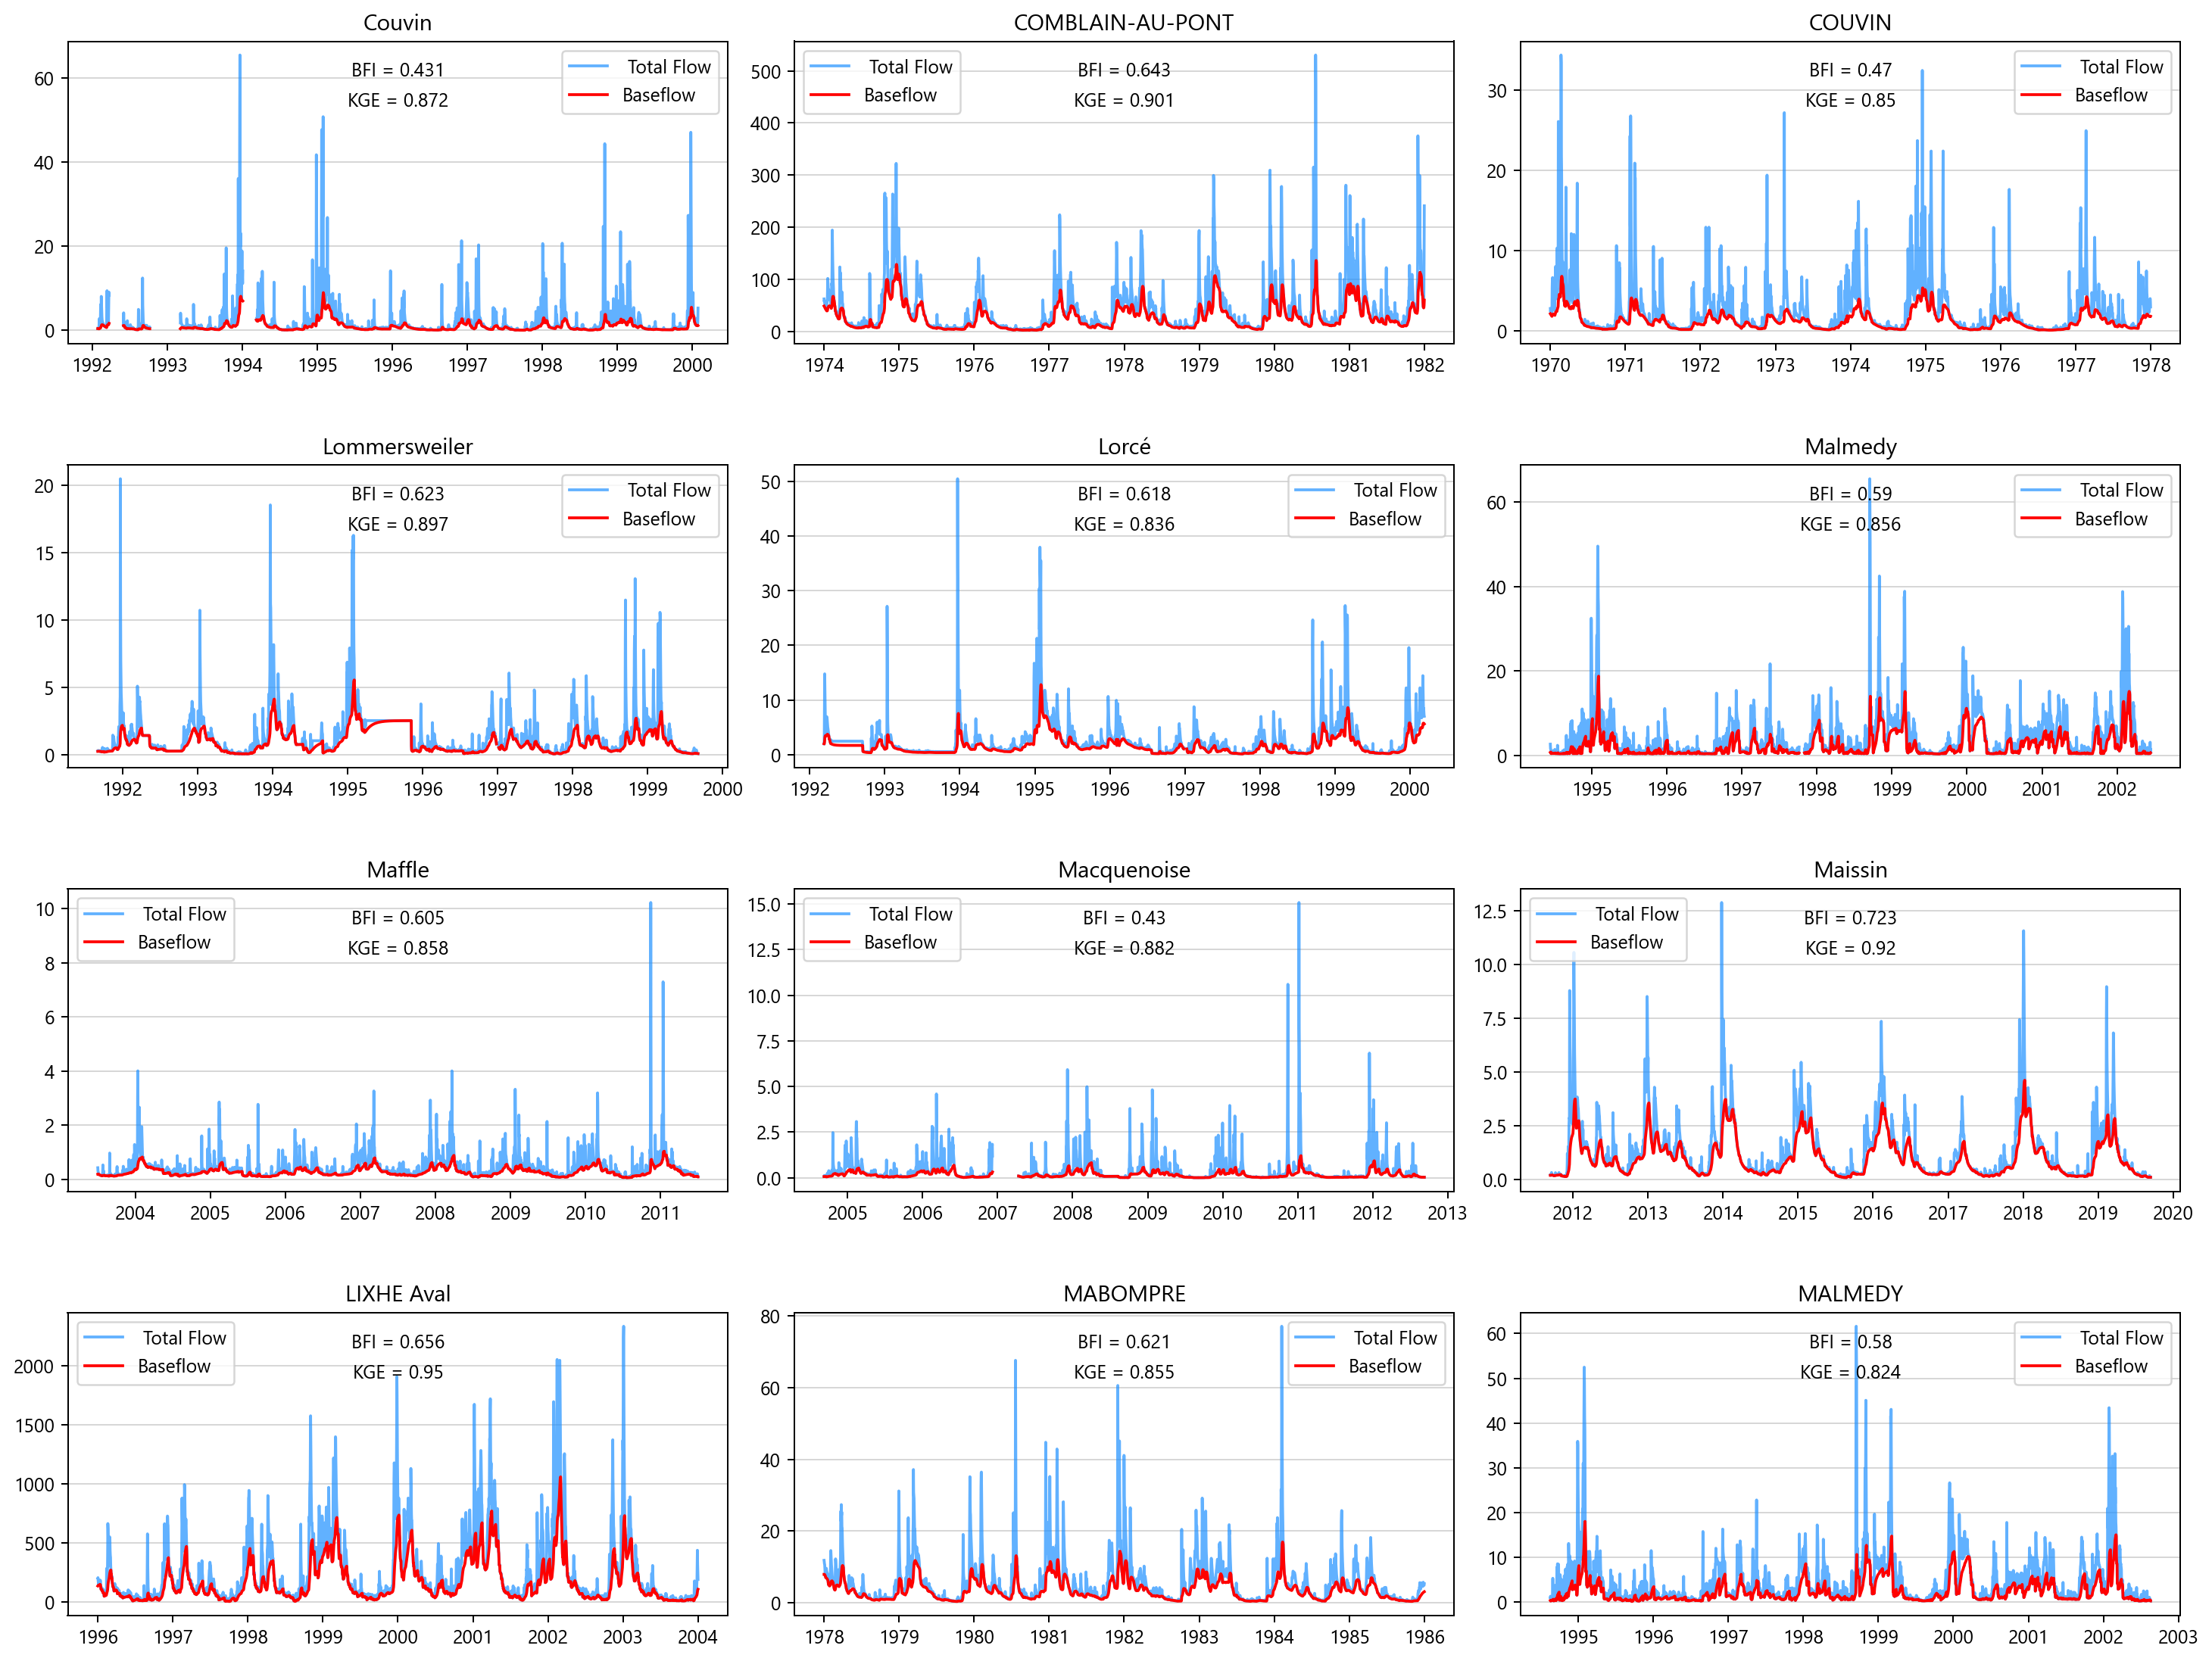

In [83]:
nrows = 4
ncols = 3

fig,axes = plt.subplots(nrows, ncols, figsize=(20,15), dpi=180)
ax = axes.flatten()

#spaces between the subplots
plt.subplots_adjust(wspace=0.1, hspace=0.4)

for ax, name in zip(ax, baseflow_dict.keys()):

    df = baseflow_dict[name]
    bfi = bfi_dict[name]
    kge = kge_dict[name]
    
    #bfi = round(bfi, 2)

    #plot the hydrograph
    min_date = df.index.min()
    max_date = min_date + pd.DateOffset(years=8)

    ax.plot(df['Q'][min_date:max_date], label=' Total Flow', color='dodgerblue', alpha=0.7)   
    ax.plot(df['Q_bf'][min_date:max_date], label='Baseflow', color='r')
    ax.set_title(name)
    ax.text(0.5, 0.9, f'BFI = {bfi}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.text(0.5, 0.8, f'KGE = {kge}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.grid(axis='y', alpha=0.5)
    ax.legend()

    #remove empty subplots
    # Remove any unused subplots


    #plot the baseflow
    # plt.plot(dfs['Willems'][min_date:max_date], label='Willems')
    # plt.plot(dfs['Eckhardt'][min_date:max_date], label='Eckhardt')
    # plt.plot(dfs['Furey'][min_date:max_date], label='Furey')
    # plt.plot(dfs['Boughton'][min_date:max_date], label='Boughton')